## **Library Importation**

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier, plot_importance
import shap
import warnings
warnings.filterwarnings("ignore")

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Data Importation**

In [36]:
df = pd.read_csv('/content/drive/MyDrive/DSCI 549/Project/healthcare-dataset-stroke-data.csv')
df.drop(columns=["id"], inplace=True)

## **Exploratory Data Analysis**

In [37]:
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


**Check Value Distribution for Each Feature**

In [39]:
for column in df.columns:
  print(df[column].value_counts())

gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64
age
78.00    102
57.00     95
52.00     90
54.00     87
51.00     86
        ... 
1.40       3
0.48       3
0.16       3
0.08       2
0.40       2
Name: count, Length: 104, dtype: int64
hypertension
0    4612
1     498
Name: count, dtype: int64
heart_disease
0    4834
1     276
Name: count, dtype: int64
ever_married
Yes    3353
No     1757
Name: count, dtype: int64
work_type
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: count, dtype: int64
Residence_type
Urban    2596
Rural    2514
Name: count, dtype: int64
avg_glucose_level
93.88     6
73.00     5
72.49     5
91.85     5
91.68     5
         ..
61.98     1
91.01     1
120.03    1
138.51    1
118.41    1
Name: count, Length: 3979, dtype: int64
bmi
28.7    41
28.4    38
27.7    37
27.6    37
26.7    37
        ..
47.9     1
13.0     1
13.9     1
54.1     1
14.9     1
Name: count, Length: 418

In [40]:
df.isna().sum()

,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
work_type,0
Residence_type,0
avg_glucose_level,0
bmi,201
smoking_status,0


In [41]:
sns.countplot(data=df, x="stroke").set_title("Target Class Distribution")
plt.savefig("stroke_distribution.png")
plt.clf()

<Figure size 640x480 with 0 Axes>

In [42]:
for col in ["age", "avg_glucose_level", "bmi"]:
    sns.histplot(df[col].dropna(), kde=True).set_title(f"Distribution of {col}")
    plt.savefig(f"dist_{col}.png")
    plt.clf()

<Figure size 640x480 with 0 Axes>

In [44]:
X = df.drop("stroke", axis=1)
y = df["stroke"]

In [45]:
numeric_features = ["age", "avg_glucose_level", "bmi"]
categorical_features = ["gender", "ever_married", "work_type", "Residence_type", "smoking_status"]

In [46]:
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

In [47]:
categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

In [48]:
preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [50]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(
        n_estimators=100, learning_rate=0.05, max_depth=4,
        subsample=0.8, colsample_bytree=0.8, scale_pos_weight=(y_train==0).sum() / (y_train==1).sum(),
        use_label_encoder=False, eval_metric="logloss", random_state=42
    ),
    "k-NN": KNeighborsClassifier(),
    "Neural Net (MLP)": MLPClassifier(hidden_layer_sizes=(50,), max_iter=1000, random_state=42)
}

In [51]:
results = []

for name, model in models.items():
    clf = Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", model)
    ])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "ROC AUC": roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    })
    print(f"\n{name} Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print(f"\n{name} Classification Report:\n", classification_report(y_test, y_pred))


Logistic Regression Confusion Matrix:
 [[972   0]
 [ 50   0]]

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.00      0.00      0.00        50

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.90      0.95      0.93      1022


Decision Tree Confusion Matrix:
 [[917  55]
 [ 41   9]]

Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.94      0.95       972
           1       0.14      0.18      0.16        50

    accuracy                           0.91      1022
   macro avg       0.55      0.56      0.55      1022
weighted avg       0.92      0.91      0.91      1022


Random Forest Confusion Matrix:
 [[968   4]
 [ 47   3]]

Random Forest Classification Report:
               precision    recall  f1-score   

In [52]:
results_df = pd.DataFrame(results).sort_values(by="F1", ascending=False)
print("\n=== Model Comparison ===")
print(results_df)
results_df.to_csv("model_results_summary.csv", index=False)


=== Model Comparison ===
                 Model  Accuracy  Precision  Recall        F1   ROC AUC
3              XGBoost  0.780822   0.157480    0.80  0.263158  0.846317
1        Decision Tree  0.906067   0.140625    0.18  0.157895  0.561708
2        Random Forest  0.950098   0.428571    0.06  0.105263  0.785998
5     Neural Net (MLP)  0.949119   0.375000    0.06  0.103448  0.801667
0  Logistic Regression  0.951076   0.000000    0.00  0.000000  0.841317
4                 k-NN  0.943249   0.000000    0.00  0.000000  0.596687


In [53]:
param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1]
}
grid_search = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric="logloss", scale_pos_weight=(y_train==0).sum() / (y_train==1).sum()), param_grid, cv=5, scoring='f1')
X_train_trans = preprocessor.fit_transform(X_train)
grid_search.fit(X_train_trans, y_train)
print("\nBest XGBoost Parameters:", grid_search.best_params_)


Best XGBoost Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150}


In [54]:
xgb_model = models["XGBoost"]
xgb_model.fit(preprocessor.fit_transform(X_train), y_train)
plot_importance(xgb_model, max_num_features=10, height=0.5)
plt.tight_layout()
plt.savefig("xgb_feature_importance.png")
plt.clf()

<Figure size 640x480 with 0 Axes>

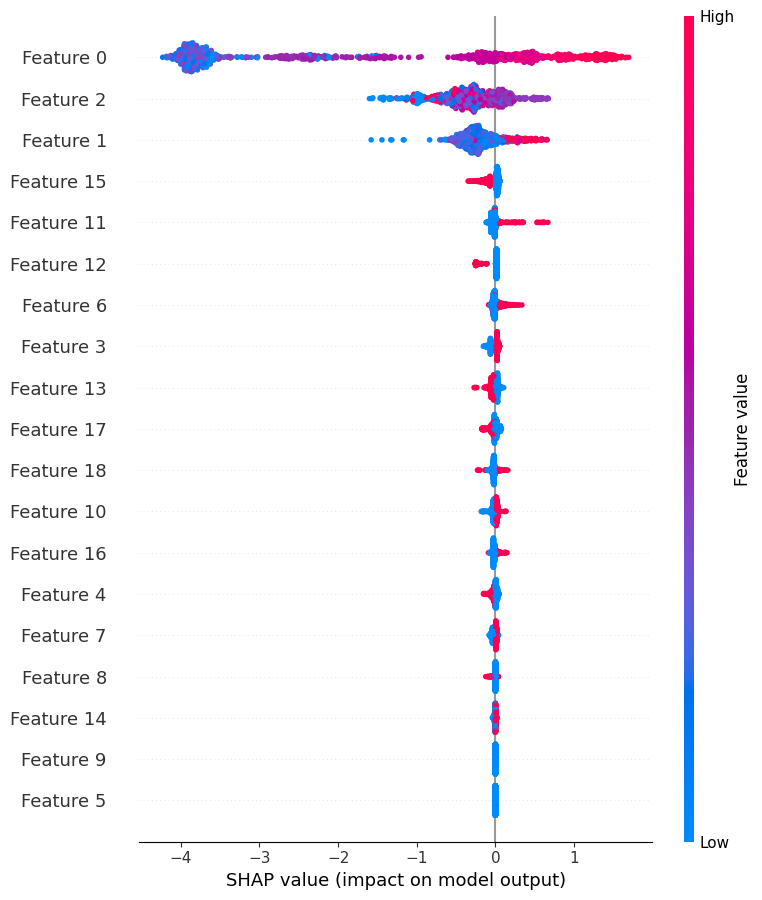

In [55]:
explainer = shap.Explainer(xgb_model)
X_transformed = preprocessor.transform(X_test)
shap_values = explainer(X_transformed)
shap.summary_plot(shap_values, X_transformed, show=False)
plt.tight_layout()
plt.savefig("shap_summary.png")